# Fine tuning Gemma - 2B model for text to sql

In [ ]:
!pip install --upgrade datasets
!pip install --upgrade transformers

In [ ]:
!pip install --upgrade peft
!pip install --upgrade trl
!pip install bitsandbytes
!pip install accelerate

In [ ]:
from huggingface_hub import notebook_login
from google.colab import userdata
hf_token = userdata.get('HF_TOKEN')
notebook_login()

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, HfArgumentParser, TrainingArguments, logging
import torch
from peft import LoraConfig, PeftModel
from trl import SFTTrainer

In [ ]:
# model based on  sql-create-context dataset
import pandas as pd
train_dataset = pd.read_csv('/content/train_dataset.csv')
test_dataset = pd.read_csv('/content/test_dataset.csv')

In [ ]:
record_0 = train_dataset.iloc[0]
print(f"Question is: {record_0['question']}")
print(f"Context is: {record_0['context']}")
print(f"Answer is: {record_0['answer']}")

Question is: what is the country with the album best of and weeks on chart is less than 5?
Context is: CREATE TABLE table_name_53 (country VARCHAR, album VARCHAR, weeks_on_chart VARCHAR)
Answer is: SELECT country FROM table_name_53 WHERE album = "best of" AND weeks_on_chart < 5


In [ ]:
# Customised dataset for finetuning the model

In [ ]:
filtered_train_dataset = []
for __, row in train_dataset.iterrows():
  text = f"Question:\n{row['question']}\n\nContext:\n{row['context']}\n\nAnswer:\n{row['answer']}"
  filtered_train_dataset.append({"text": text})

In [ ]:
filtered_test_dataset = []
for __, row in test_dataset.iterrows():
  text = f"Question:\n{row['question']}\n\nContext:\n{row['context']}\n\nAnswer:\n{row['answer']}"
  filtered_test_dataset.append({"text": text})

In [ ]:
# Finetuning parameters
model_name = "google/gemma-2b"
new_model = "gemma-finetuned"

# LoRA parameters
lora_r = 4
lora_alpha = 16
lora_dropout = 0.1

# Bits and bytes parameters
use_4bit = True
bnb_4bit_compute_dtype = "float16"
bnb_4bit_quant_type = "nf4"
use_nested_quant = False

# Training arguments
output_dir = "./results"
num_train_epochs = 1
fp16 = False
bf16 = False
per_device_train_batch_size = 8
per_device_eval_batch_size = 8
gradient_accumulation_steps = 1
gradient_checkpointing = True
max_grad_norm = 0.3
learning_rate = 2e-4
weight_decay = 0.001
optim = "paged_adamw_32bit"
lr_scheduler_type = "constant"
max_steps = -1
warmup_ratio = 0.03
group_by_length = True
save_steps = 1000
logging_steps = 100

# SFT Parameters
max_seq_length = 40
packing = True
device_map = "auto"

In [ ]:
# Load QLoRA configuration
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

In [ ]:
# Load base model
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    token=hf_token,
    quantization_config=bnb_config,
    device_map=device_map
)
model.config.use_cache = False
model.config.pretraining_tp = 1

tokenizer = AutoTokenizer.from_pretrained(model_name,
                                          token=hf_token,
                                          trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

In [ ]:
# Load LoRA configuration
peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj","gate_proj", "up_proj"]
)

In [ ]:
# Set training parameters
training_arguments = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    fp16=fp16,
    bf16=bf16,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=group_by_length,
    lr_scheduler_type=lr_scheduler_type,
)

In [ ]:
trainer = SFTTrainer(
    model=model,
    train_dataset=filtered_train_dataset,
    peft_config=peft_config,
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    args=training_arguments,
    packing=packing,
)

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
trainer.train()
trainer.model.save_pretrained(new_model)

# Gemma-finetuned model

In [ ]:
input_text = f'What is the country with the album best of and weeks on chart is less than 5? CREATE TABLE table_name_53 (country VARCHAR, album VARCHAR, weeks_on_chart VARCHAR)'
new_model = "/content/gemma-finetuned"
base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    low_cpu_mem_usage=True,
    return_dict=True,
    torch_dtype=torch.float16,
    device_map=device_map,
)
model = PeftModel.from_pretrained(base_model, new_model)
model = model.merge_and_unload()

# Reload tokenizer to save it
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
import re
import pandas as pd

extracted_queries = []

# Process only the top 1000 rows
for __, row in test_dataset.head(1000).iterrows():
    input_text = f"{row['question']}{row['context']}"
    input_ids = tokenizer(input_text, return_tensors="pt").to("cuda")
    outputs = model.generate(**input_ids, max_length=128)
    answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
    pattern = r"Answer:\s*(.*)"
    extracted_query = re.search(pattern, answer).group(1)
    extracted_queries.append(extracted_query)

# Create a new column 'gemma_query' with None as the default value for all rows
test_dataset['gemma_query'] = [None] * len(test_dataset)

test_dataset.loc[test_dataset.head(1000).index, 'gemma_query'] = extracted_queries
test_dataset.to_csv('./')

# Finetuned output dataset

In [ ]:
test_dataset = test_dataset[:1000]
test_dataset

,answer,question,context,gemma_query
0,SELECT MIN(laps) FROM table_name_8 WHERE grid ...,What was the number of Laps with a Grid of mor...,"CREATE TABLE table_name_8 (laps INTEGER, grid ...",SELECT AVG(laps) FROM table_name_8 WHERE grid ...
1,SELECT senior_status FROM table_name_18 WHERE ...,"Which Senior status has a Chief Judge of —, a ...",CREATE TABLE table_name_18 (senior_status VARC...,SELECT senior_status FROM table_name_18 WHERE ...
2,SELECT MAX(rank) FROM table_name_98 WHERE reac...,"Which Rank has a Reaction of 0.198, and a Time...","CREATE TABLE table_name_98 (rank INTEGER, reac...",SELECT SUM(rank) FROM table_name_98 WHERE reac...
3,SELECT narrated_by FROM table_26168687_3 WHERE...,Who narrated when the vessel operator is de be...,CREATE TABLE table_26168687_3 (narrated_by VAR...,SELECT narrated_by FROM table_26168687_3 WHERE...
4,SELECT original_season FROM table_name_15 WHER...,What's the original season in 11th place?,CREATE TABLE table_name_15 (original_season VA...,SELECT original_season FROM table_name_15 WHER...
...,...,...,...,...
996,SELECT COUNT(district) FROM table_1342315_17 W...,How many districts does riley joseph wilson?,CREATE TABLE table_1342315_17 (district VARCHA...,SELECT COUNT(district) FROM table_1342315_17 W...
997,SELECT to_par FROM table_name_76 WHERE player ...,What is Sandy Lyle's To Par?,"CREATE TABLE table_name_76 (to_par VARCHAR, pl...",SELECT to_par FROM table_name_76 WHERE player ...
998,SELECT investing_dragon_s_ FROM table_name_74 ...,"Which Investing Dragon(s) requested 100,000 in...",CREATE TABLE table_name_74 (investing_dragon_s...,SELECT investing_dragon_s_ FROM table_name_74 ...
999,SELECT high_points FROM table_27700530_15 WHER...,Who had the most points and how many did they ...,CREATE TABLE table_27700530_15 (high_points VA...,SELECT high_points FROM table_27700530_15 WHER...


No charts were generated by quickchart


In [ ]:
from google.colab import files
test_dataset.to_csv('test_dataset_output.csv', index=False)
files.download('test_dataset_output.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#sft
test_dataset_output = pd.read_csv('/content/test_dataset_output.csv')
test_dataset_analysis = test_dataset_output.copy()

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!pip install rouge
!pip install evaluate
from rouge import Rouge
from evaluate import load

# Results after fine tuning

In [ ]:
#sft
# Calculate the average of each score column
average_rouge1 = test_dataset_analysis['rouge1'].mean()
average_rouge2 = test_dataset_analysis['rouge2'].mean()
average_rougeL = test_dataset_analysis['rougeL'].mean()
average_exact_match = test_dataset_analysis['exact_match'].mean()
average_bleu_score = test_dataset_analysis['bleu_score'].mean()

# Print the average scores
print(f'Average Rouge-1: {average_rouge1}')
print(f'Average Rouge-2: {average_rouge2}')
print(f'Average Rouge-L: {average_rougeL}')
print(f'Average Exact Match: {average_exact_match}')
print(f'Average BLEU Score: {average_bleu_score}')


Average Rouge-1: 0.927707487813024
Average Rouge-2: 0.878772859133305
Average Rouge-L: 0.9238148263148144
Average Exact Match: 0.597
Average BLEU Score: 0.8883326277035732


In [ ]:
# prompt: can you generate visualization for above average scores

import matplotlib.pyplot as plt

# Prepare data
labels = ['Rouge-1', 'Rouge-2', 'Rouge-L', 'Exact Match', 'BLEU Score']
average_scores = [average_rouge1, average_rouge2, average_rougeL, average_exact_match, average_bleu_score]

# Create bar chart
plt.figure(figsize=(10, 6))
plt.bar(labels, average_scores, color='blue')

# Add title and axis labels
plt.title('Average Scores for Prompt Engineering and SFT Models')
plt.xlabel('Metrics')
plt.ylabel('Average Score')

# Show plot
plt.show()


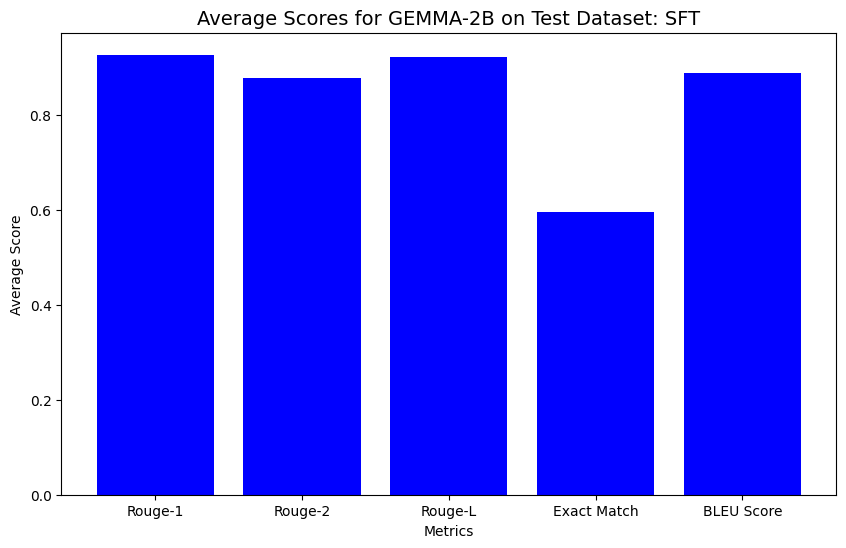

In [5]:
# prompt: Average Rouge-1: 0.927707487813024
# Average Rouge-2: 0.878772859133305
# Average Rouge-L: 0.9238148263148144
# Average Exact Match: 0.597
# Average BLEU Score: 0.8883326277035732 can you draw visualization

import matplotlib.pyplot as plt
# Prepare data
labels = ['Rouge-1', 'Rouge-2', 'Rouge-L', 'Exact Match', 'BLEU Score']
average_scores = [0.927707487813024, 0.878772859133305, 0.9238148263148144, 0.597, 0.8883326277035732]

# Create bar chart
plt.figure(figsize=(10, 6))
plt.bar(labels, average_scores, color='blue')

# Add title and axis labels
plt.title('Average Scores for GEMMA-2B on Test Dataset: SFT', fontsize=14)
plt.xlabel('Metrics')
plt.ylabel('Average Score')

# Show plot
plt.show()
